In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
        'axes.labelsize': 'large',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'medium',
        'axes.titleweight': 'bold',
        'legend.fontsize': 'small',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
        'figure.facecolor': '1.00'
    })
# Styles for plots
ccolors = {'control': 'black',
           'smoking': 'blue',
           'oc': 'green',
           'outlier': 'red',
          }
markers = {'control': 's',
           'smoking': 'd',
           'oc': 'o',
            'outlier': 'x',

          }

category_filter = {
    'control':{
        ('smoking', 'choice'):"N",
        ('oral contraceptives', 'choice'):'N',
       'outlier':False
    },
    'smoking':{
        ('smoking', 'choice'):"Y",
        'outlier':False
    }, 
    'oc':{
        ('oral contraceptives', 'choice'):'Y',
        'outlier':False
    },
    'outlier':{
        'outlier':True
    }}

from utils import PkdbModel


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
all_complete = PkdbModel("all_complete", destination="2-merged")
all_complete.read()

all_complete.data.loc[(all_complete.data[("sex","choice")] == "M"),("oral contraceptives","choice")] = "N"


In [4]:
def convert_unit(df, unit_in, unit_out, factor=1.0, 
                 unit_field="unit", data_fields=['mean','median','value', 'sd', 'se', 'min', 'max'], inplace=True, subset=False):
    """ Unit conversion in given data frame. """
    if not inplace:
        df = df.copy()
    if subset:
        is_weightidx =  df[subset].notnull()
        df =  df[is_weightidx]     
    if isinstance(factor, pd.Series):
        factor = factor[is_weightidx]
        
        
    idx = (df[unit_field] == unit_in)
    

    for key in data_fields:
        df.loc[idx, key] = df.loc[idx, key]*factor
    df.loc[idx, unit_field] = unit_out
    
    if subset:
        return df[idx]
    
    return df

In [5]:
def caffeine_idx(data):
    return (data.substance_name_intervention == 'caffeine') \
           & (data.substance_name == 'caffeine') \
           & (data[ ('healthy', 'choice')] == 'Y') \
           & (data['tissue'] == 'plasma')

def pktype_data(data,pktype):
    return data[data.pktype==pktype]
    
complete_caffeine = all_complete.data[caffeine_idx(all_complete.data)]

def abs_idx(data,unit_field):
    return ~rel_idx(data,unit_field)

def rel_idx(data,unit_field):
    return data[unit_field].str.contains('kg')

def filter_out(data,unit_field,units):
    return data[~data[unit_field].isin(units)]

def filter_df(filter_dict, df):
    for filter_key, filter_value in filter_dict.items():
        df = df[df[filter_key]==filter_value]
    return df

def group_idx(data):
    return data["subject_type"] == 'group'

def individual_idx(data):
    return data["subject_type"] == 'individual'

In [14]:
caffeine_clearance = pktype_data(complete_caffeine,"clearance")
caffeine_clearance = filter_out(caffeine_clearance,"unit",["ml/min/1.73m^2"])
#caffeine_clearance = filter_out(caffeine_clearance,"study",["Balogh1992"])
caffeine_clearance["outlier"] = False
caffeine_clearance.loc[caffeine_clearance["study"]== "Balogh1992","outlier"] = True

caffeine_clearance[("weight","value")] = pd.to_numeric(caffeine_clearance[("weight","value")])
caffeine_clearance[("weight","mean")] = pd.to_numeric(caffeine_clearance[("weight","mean")])

caffeine_clearance["value_intervention"] = pd.to_numeric(caffeine_clearance["value_intervention"])
caffeine_clearance["median"] = pd.to_numeric(caffeine_clearance["median"])
caffeine_clearance["mean"] = pd.to_numeric(caffeine_clearance["mean"])
caffeine_clearance["value"] = pd.to_numeric(caffeine_clearance["value"])
caffeine_clearance["se"] = pd.to_numeric(caffeine_clearance["se"])
caffeine_clearance["sd"] = pd.to_numeric(caffeine_clearance["sd"])
caffeine_clearance["cv"] = pd.to_numeric(caffeine_clearance["cv"])


caffeine_clearance.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  tissue  substance_name  \
unit   unit_intervention                                                    
l/h    mg                   159          159  159     159             159   
       mg/kg                 11           11   11      11              11   
l/h/kg mg                   204          204  204     204             204   
       mg/kg                 24           24   24      24              24   

                          pktype  interventions  individual_pk  value  \
unit   unit_intervention                                                
l/h    mg                    159            159            149    149   
       mg/kg                  11             11              0      0   
l/h/kg mg                    204            204            169    166   
       mg/kg                  24             24             15     15   

                          time_unit   ...     (percent fat, mean)  \
unit   unit_intervention              ...                           
l/h    mg                        12   ...                       0   
       mg/kg                      5   ...                       0   
l/h/kg mg                        10   ...                       0   
       mg/kg                      0   ...                       0   

                          (percent fat, sd)  (percent fat, se)  \
unit   unit_intervention                                         
l/h    mg                                 0                  0   
       mg/kg                              0                  0   
l/h/kg mg                                 0                  0   
       mg/kg                              0                  0   

                          (percent fat, unit)  (metabolic ratio, count)  \
unit   unit_intervention                                                  
l/h    mg                                   0                         0   
       mg/kg                                0                         0   
l/h/kg mg                                   0                         0   
       mg/kg                                0                         0   

                          (metabolic ratio, max)  (metabolic ratio, mean)  \
unit   unit_intervention                                                    
l/h    mg                                      0                        0   
       mg/kg                                   0                        0   
l/h/kg mg                                      0                        0   
       mg/kg                                   0                        0   

                          (metabolic ratio, min)  (metabolic ratio, unit)  \
unit   unit_intervention                                                    
l/h    mg                                      0                        0   
       mg/kg                                   0                        0   
l/h/kg mg                                      0                        0   
       mg/kg                                   0                        0   

                          outlier  
unit   unit_intervention           
l/h    mg                     159  
       mg/kg                   11  
l/h/kg mg                     204  
       mg/kg                   24  

[4 rows x 222 columns]

In [15]:
caffeine_clearance_rel = convert_unit(caffeine_clearance,
                             unit_in="mg",
                             unit_out="mg/kg", 
                             factor=1.0/caffeine_clearance[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'], 
                             subset=("weight","value"))

caffeine_clearance_abs = convert_unit(caffeine_clearance,
                             unit_in="mg/kg",
                             unit_out="mg", 
                             factor=caffeine_clearance[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'],
                             subset=("weight","value"))



caffeine_clearance = pd.concat([caffeine_clearance,caffeine_clearance_rel,caffeine_clearance_abs], ignore_index=True)


caffeine_clearance_rel = convert_unit(caffeine_clearance,
                             unit_in="l/h",
                             unit_out="l/h/kg", 
                             factor=1.0/caffeine_clearance[("weight","value")],
                             unit_field="unit", 
                             data_fields=['value'], 
                             subset=("weight","value"))

caffeine_clearance_abs = convert_unit(caffeine_clearance,
                             unit_in="l/h/kg",
                             unit_out="l/h", 
                             factor=caffeine_clearance[("weight","value")],
                             unit_field="unit", 
                             data_fields=['value'],
                             subset=("weight","value"))


caffeine_clearance = pd.concat([caffeine_clearance,caffeine_clearance_rel,caffeine_clearance_abs], ignore_index=True)

caffeine_clearance_rel = convert_unit(caffeine_clearance,
                             unit_in="mg",
                             unit_out="mg/kg", 
                             factor=1.0/caffeine_clearance[("weight","mean")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'], 
                             subset=("weight","mean"))

caffeine_clearance_abs = convert_unit(caffeine_clearance,
                             unit_in="mg/kg",
                             unit_out="mg", 
                             factor=caffeine_clearance[("weight","mean")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'],
                             subset=("weight","mean"))
caffeine_clearance = pd.concat([caffeine_clearance,caffeine_clearance_rel,caffeine_clearance_abs], ignore_index=True)


caffeine_clearance_rel = convert_unit(caffeine_clearance,
                             unit_in="l/h",
                             unit_out="l/h/kg", 
                             factor=1.0/caffeine_clearance[("weight","mean")],
                             unit_field="unit", 
                             data_fields=['mean','median','sd', 'se', "cv"],
                             subset=("weight","mean"))

caffeine_clearance_abs = convert_unit(caffeine_clearance,
                             unit_in="l/h/kg",
                             unit_out="l/h", 
                             factor=caffeine_clearance[("weight","mean")],
                             unit_field="unit", 
                             data_fields=['mean','median','sd', 'se', "cv"],
                             subset=("weight","mean"))


caffeine_clearance = pd.concat([caffeine_clearance,caffeine_clearance_rel,caffeine_clearance_abs], ignore_index=True)

In [22]:
caffeine_clearance[group_idx(caffeine_clearance)].groupby(["unit","unit_intervention"]).count()

study  output_type  pk  tissue  substance_name  \
unit   unit_intervention                                                   
l/h    mg                    47           47  47      47              47   
       mg/kg                 43           43  43      43              43   
l/h/kg mg                    61           61  61      61              61   
       mg/kg                 43           43  43      43              43   

                          pktype  interventions  individual_pk  value  \
unit   unit_intervention                                                
l/h    mg                     47             47              0      0   
       mg/kg                  43             43              0      0   
l/h/kg mg                     61             61              0      0   
       mg/kg                  43             43              0      0   

                          time_unit   ...     (percent fat, mean)  \
unit   unit_intervention              ...                           
l/h    mg                         6   ...                       0   
       mg/kg                      6   ...                       0   
l/h/kg mg                         7   ...                       0   
       mg/kg                      6   ...                       0   

                          (percent fat, sd)  (percent fat, se)  \
unit   unit_intervention                                         
l/h    mg                                 0                  0   
       mg/kg                              0                  0   
l/h/kg mg                                 0                  0   
       mg/kg                              0                  0   

                          (percent fat, unit)  (metabolic ratio, count)  \
unit   unit_intervention                                                  
l/h    mg                                   0                         0   
       mg/kg                                0                         0   
l/h/kg mg                                   0                         0   
       mg/kg                                0                         0   

                          (metabolic ratio, max)  (metabolic ratio, mean)  \
unit   unit_intervention                                                    
l/h    mg                                      0                        0   
       mg/kg                                   0                        0   
l/h/kg mg                                      0                        0   
       mg/kg                                   0                        0   

                          (metabolic ratio, min)  (metabolic ratio, unit)  \
unit   unit_intervention                                                    
l/h    mg                                      0                        0   
       mg/kg                                   0                        0   
l/h/kg mg                                      0                        0   
       mg/kg                                   0                        0   

                          outlier  
unit   unit_intervention           
l/h    mg                      47  
       mg/kg                   43  
l/h/kg mg                      61  
       mg/kg                   43  

[4 rows x 222 columns]

In [24]:

caffeine_clearance.study.unique()

array(['Benowitz2003', 'Seng2009', 'Akinyinka2000', 'Renner1984',
       'Campbell1987a', 'Fuhr1993a', 'Kaplan1997', 'Carrillo2000a',
       'Abernethy1985', 'Harder1988', 'Patwardhan1980', 'Bonati1982',
       'ZylberKatz1984', 'Perera2011', 'Joeres1988', 'Carbo1989',
       'Haller2002', 'Test243', 'Harder1989', 'Desmond1980',
       'Spigset1999a', 'Balogh1992', 'Cheng1990', 'Culm-Merdek2005'],
      dtype=object)

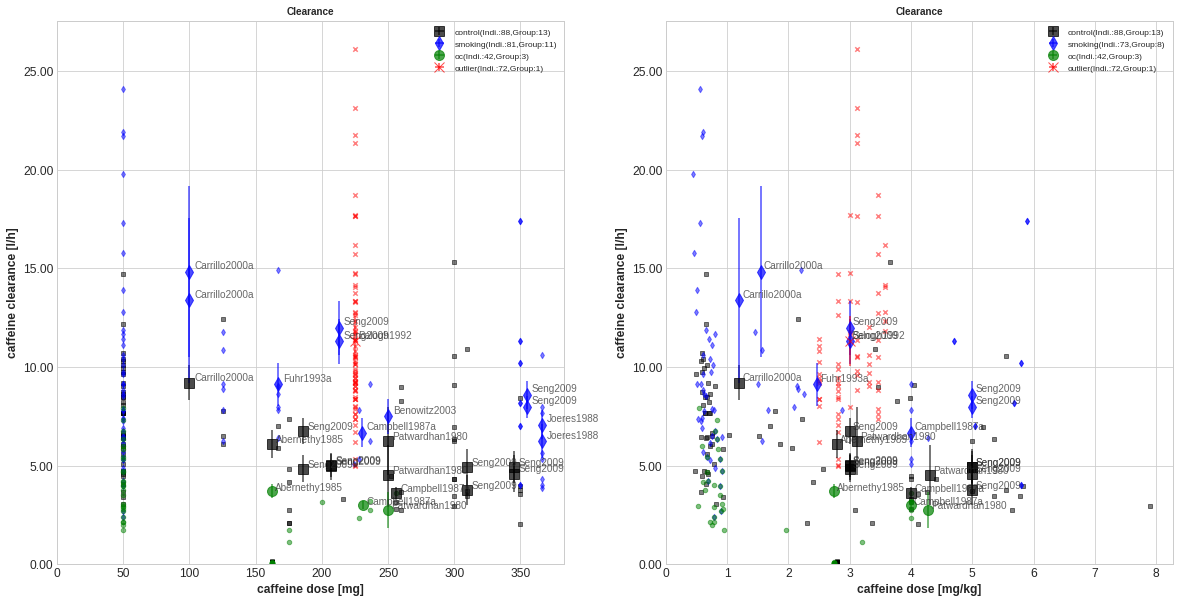

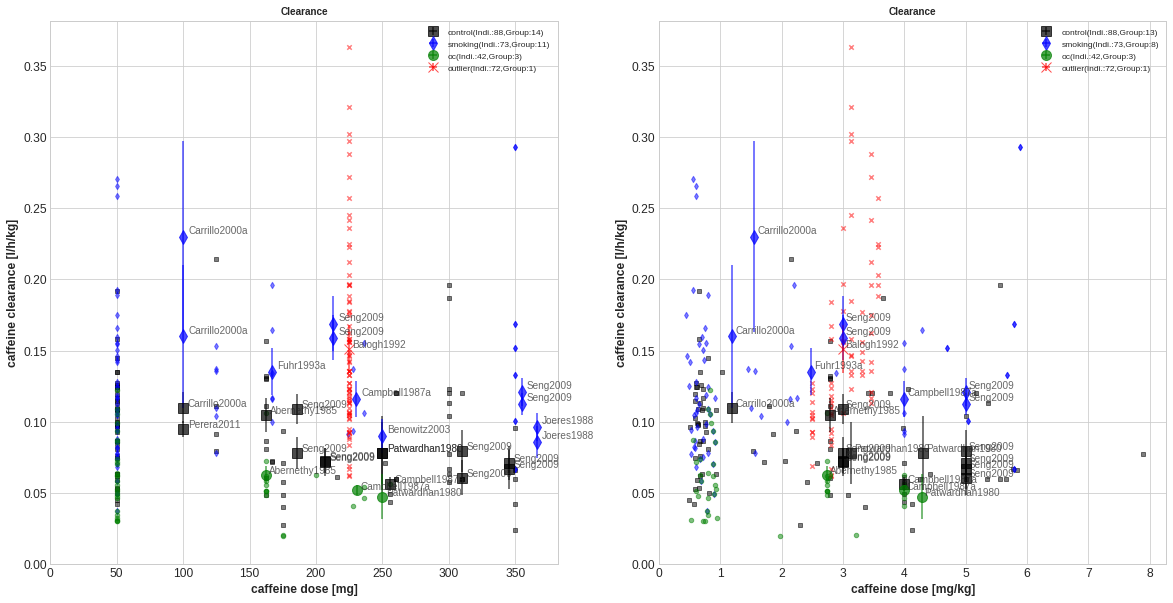

In [18]:
# caffeine clearance
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
dinds = [abs_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit"),
         rel_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit"),
         abs_idx(caffeine_clearance,"unit_intervention") & rel_idx(caffeine_clearance,"unit"),
         rel_idx(caffeine_clearance,"unit_intervention") & rel_idx(caffeine_clearance,"unit")]

for ax, inds in zip((ax1, ax2, ax3, ax4), dinds):
    df = caffeine_clearance[inds & individual_idx(caffeine_clearance)]
    df_group = caffeine_clearance[inds & group_idx(caffeine_clearance)]

    for category in ccolors:
        cf_filter = category_filter[category]
        df_category = filter_df(cf_filter,df)
        x = df_category["value_intervention"]
        y = df_category["value"]
        ax.scatter(x, y,color=ccolors[category], marker=markers[category], alpha=0.5,label=None,  s=20)
        units = df_category["unit"].unique()
        unit_intervention = df_category["unit_intervention"].unique()

        assert len(units) <= 1, units
        try:
            ax.set_ylabel(f'caffeine clearance [{units[0]}]')
            ax.set_xlabel(f'caffeine dose [{unit_intervention[0]}]')
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        except IndexError: 
            pass
        
        df_category = filter_df(cf_filter,df_group)
        df_category = df_category[df_category["mean"].notnull()]

        x_group = df_category["value_intervention"]
        y_group = df_category["mean"]
        #count_group = list(df_category[("weight","count")])
        if ax in (ax2, ax4):
            xerr_group = (df_category[("weight","sd")]/df_category[("weight","mean")])*x_group
        else:
            xerr_group = 0
        yerr_group = df_category["se"]

        ax.errorbar(x_group, y_group,yerr=yerr_group,xerr=0,color=ccolors[category], fmt=markers[category],  label=f"{category}(Indi.:{len(x)},Group:{len(x_group)})",ms=10, alpha=0.7)
        for i, txt in enumerate(df_category[('study', '')]):
            ax.annotate(txt, (x_group.iloc[[i]]+(0.01*x_group.max()),
                              y_group.iloc[[i]]+(0.01*y_group.max())), alpha=0.7)
        
            

        #sns.distplot( y,ax =ax,color=ccolors[category],  label=f"{category}({len(x)})",kde_kws={'clip': (0.0,100000 )})
        #for i, txt in enumerate(df_category[('study', '')]):
        #    ax.annotate(txt, (x.iloc[[i]],
        #                      y.iloc[[i]]), alpha=0.7)
    
for ax in (ax1, ax2, ax3, ax4):

    ax.set_title('Clearance')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.legend()

fig1.savefig("reports/caf_cl_01.svg", bbox_inches="tight")
